## Predicting Stock Price Movements 

#### import all needed libraries for this project

In [1]:
import pandas as pd
import numpy as np
from data_processing import Training_Data
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import IPython
import IPython.display
from ta import add_all_ta_features
from pykalman import KalmanFilter
import yfinance as yf

##### Using the yfinance historical data api to fetch stock price data in a given timeframe

In [2]:
spy = yf.Ticker("SPY")
df = spy.history(period="max", actions=False)

#### view dataframe from API response

In [3]:
df=df.reset_index()
df.head()


,Date,Open,High,Low,Close,Volume
0,1993-01-29,25.352045,25.352045,25.225915,25.334026,1003200
1,1993-02-01,25.352049,25.514215,25.352049,25.514215,480500
2,1993-02-02,25.496190,25.586283,25.442134,25.568264,201300
3,1993-02-03,25.604312,25.856571,25.586293,25.838552,529400
4,1993-02-04,25.928639,26.000713,25.640342,25.946657,531500


#### figure 1:  SPY stock price since 2015-12-01

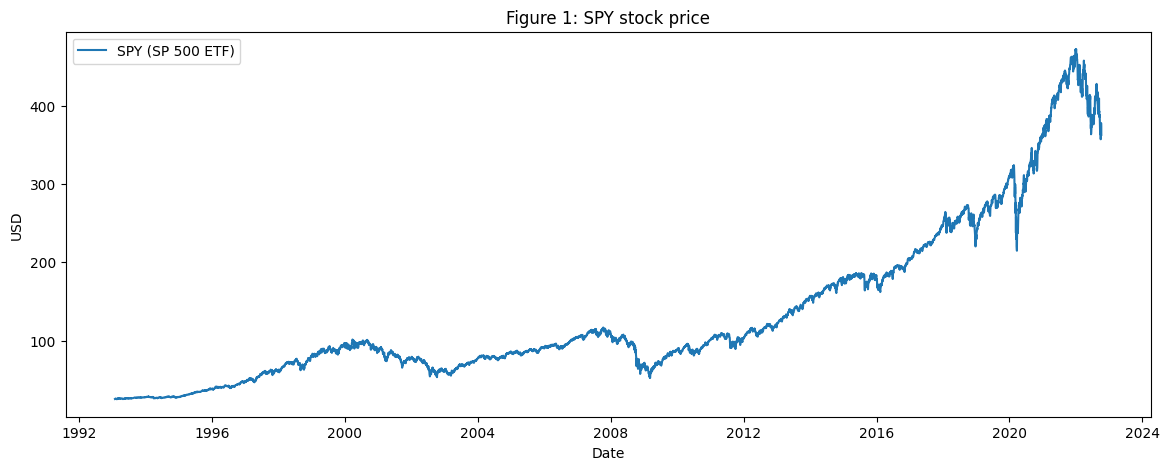

In [4]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(df['Date'], df['Close'], label='SPY (SP 500 ETF)')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 1: SPY stock price')
plt.legend()
plt.show()

#### encode the timestamp with sin and cos to capture periodicity of the timeseries

In [5]:
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

#### apply to both month and day

In [6]:
df['month'] = df.Date.dt.month
df = encode(df, 'month', 12)

df['day'] = df.Date.dt.day
df = encode(df, 'day', 31)

In [7]:
df.head()

,Date,Open,High,Low,Close,Volume,month,month_sin,month_cos,day,day_sin,day_cos
0,1993-01-29,25.352045,25.352045,25.225915,25.334026,1003200,1,0.500000,0.866025,29,-0.394356,0.918958
1,1993-02-01,25.352049,25.514215,25.352049,25.514215,480500,2,0.866025,0.500000,1,0.201299,0.979530
2,1993-02-02,25.496190,25.586283,25.442134,25.568264,201300,2,0.866025,0.500000,2,0.394356,0.918958
3,1993-02-03,25.604312,25.856571,25.586293,25.838552,529400,2,0.866025,0.500000,3,0.571268,0.820763
4,1993-02-04,25.928639,26.000713,25.640342,25.946657,531500,2,0.866025,0.500000,4,0.724793,0.688967


In [8]:
df = df.drop(columns=['month', 'day', 'Date'])

In [9]:
df.head()

,Open,High,Low,Close,Volume,month_sin,month_cos,day_sin,day_cos
0,25.352045,25.352045,25.225915,25.334026,1003200,0.500000,0.866025,-0.394356,0.918958
1,25.352049,25.514215,25.352049,25.514215,480500,0.866025,0.500000,0.201299,0.979530
2,25.496190,25.586283,25.442134,25.568264,201300,0.866025,0.500000,0.394356,0.918958
3,25.604312,25.856571,25.586293,25.838552,529400,0.866025,0.500000,0.571268,0.820763
4,25.928639,26.000713,25.640342,25.946657,531500,0.866025,0.500000,0.724793,0.688967


#### For now, we add all technical indicators available in the ta library for exploration purposes. The less descriptive TI's will be discarded. 

In [10]:
# Add all ta features
df = add_all_ta_features(
    df, open="Open", high="High", low="Low", close="Close", volume="Volume")

/usr/local/lib/python3.9/site-packages/ta/trend.py:780: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/usr/local/lib/python3.9/site-packages/ta/trend.py:785: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


In [11]:
df = df[['Open', 'High', 'Low', 'Close', 'Volume', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'momentum_rsi', 'trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow', 'momentum_stoch', 'trend_macd', 'momentum_wr', 'momentum_rsi']]
df['pct_change'] = df['Close'].pct_change()
df = df.dropna()

#### in addition, we will also add kalman filter as a feature and eventually FinBERT (although sentiment is more difficult to attain, but we have done it before)

In [12]:
# Construct a Kalman filter
kf = KalmanFilter(transition_matrices = [1],    # The value for At. It is a random walk so is set to 1.0
                  observation_matrices = [1],   # The value for Ht.
                  initial_state_mean = 0,       # Any initial value. It will converge to the true state value.
                  initial_state_covariance = 1, # Sigma value for the Qt in Equation (1) the Gaussian distribution
                  observation_covariance=1,     # Sigma value for the Rt in Equation (2) the Gaussian distribution
                  transition_covariance=.01)    # A small turbulence in the random walk parameter 1.0
# Get the Kalman smoothing
state_means, _ = kf.filter(df['Close'].values)
state_means

array([[ 13.18955326],
       [ 17.61387471],
       [ 19.86619595],
       ...,
       [378.35379735],
       [377.86354394],
       [376.42967506]])

In [13]:
df['KF_mean'] = np.array(state_means)
df.head()


,Open,High,Low,Close,Volume,month_sin,month_cos,day_sin,day_cos,momentum_rsi,trend_sma_fast,trend_sma_slow,trend_ema_fast,trend_ema_slow,momentum_stoch,trend_macd,momentum_wr,momentum_rsi,pct_change,KF_mean
25,25.856570,26.379107,25.856570,26.379107,50800,1.0,6.123234e-17,0.998717,-0.050649,70.009574,25.643343,25.618167,25.773508,25.627891,100.000000,0.145616,-0.000000,70.009574,0.022347,13.189553
26,26.325052,26.343070,26.234959,26.289015,169300,1.0,6.123234e-17,0.968077,-0.250653,66.827690,25.740945,25.654898,25.852816,25.676863,94.680909,0.175953,-5.319091,66.827690,-0.003415,17.613875
27,26.289012,26.343067,26.180901,26.343067,194400,1.0,6.123234e-17,0.897805,-0.440394,67.774030,25.835544,25.686776,25.928240,25.726212,97.402450,0.202028,-2.597550,67.774030,0.002056,19.866196
28,26.361083,26.433157,26.234953,26.270990,70900,1.0,6.123234e-17,0.790776,-0.612106,65.106781,25.925636,25.713804,25.980971,25.766566,88.157872,0.214405,-11.842128,65.106781,-0.002736,21.219977
29,26.054773,26.072791,25.838551,26.000717,643600,1.0,6.123234e-17,0.651372,-0.758758,56.178594,25.966178,25.720041,25.984008,25.783910,68.421319,0.200098,-31.578681,56.178594,-0.010288,22.086473


Text(0, 0.5, 'Price')

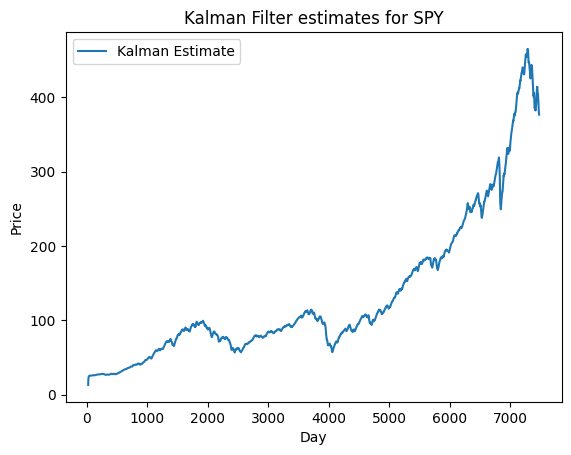

In [14]:
df[['KF_mean']].plot()
plt.title('Kalman Filter estimates for SPY')
plt.legend(['Kalman Estimate'])
plt.xlabel('Day')
plt.ylabel('Price')


Text(0.5, 1.0, 'Time of day signal')

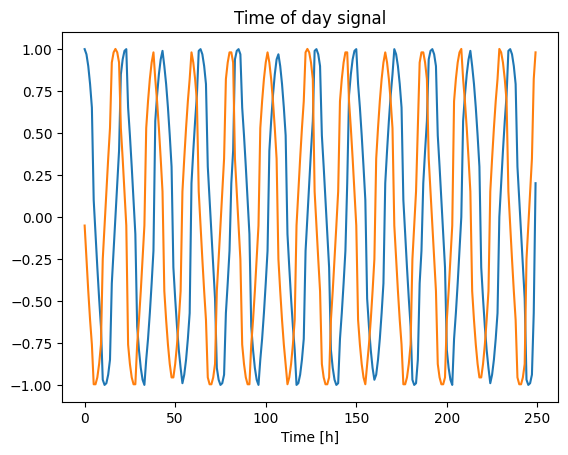

In [15]:
plt.plot(np.array(df['day_sin'])[:250])
plt.plot(np.array(df['day_cos'])[:250])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

Text(0.5, 1.0, 'Time of month signal')

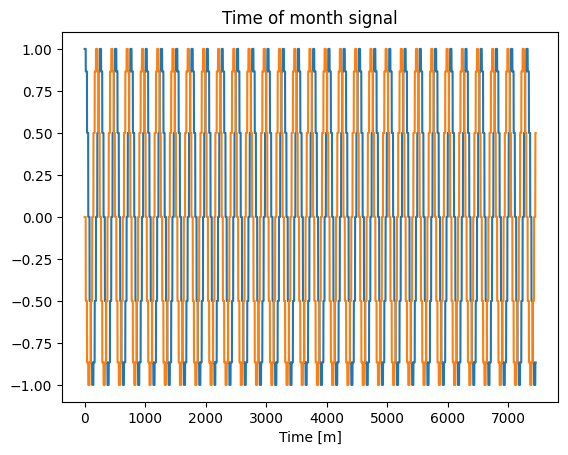

In [16]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.plot(np.array(df['month_sin']))
plt.plot(np.array(df['month_cos']))
plt.xlabel('Time [m]')
plt.title('Time of month signal')

In [17]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Open,7453.0,1.337714e+02,1.016037e+02,2.510971e+01,7.129318e+01,9.380865e+01,1.781425e+02,4.737350e+02
High,7453.0,1.345670e+02,1.021635e+02,2.541747e+01,7.186494e+01,9.451284e+01,1.789916e+02,4.744863e+02
Low,7453.0,1.328872e+02,1.009780e+02,2.507351e+01,7.062014e+01,9.301980e+01,1.771937e+02,4.706112e+02
Close,7453.0,1.337727e+02,1.016098e+02,2.514592e+01,7.126560e+01,9.382598e+01,1.782959e+02,4.722423e+02
Volume,7453.0,8.482737e+07,9.414042e+07,5.200000e+03,9.181800e+06,6.131520e+07,1.190009e+08,8.710263e+08
month_sin,7453.0,-9.801074e-03,7.083188e-01,-1.000000e+00,-8.660254e-01,-2.449294e-16,5.000000e-01,1.000000e+00
month_cos,7453.0,-1.905462e-02,7.056624e-01,-1.000000e+00,-8.660254e-01,-1.836970e-16,5.000000e-01,1.000000e+00
day_sin,7453.0,6.829124e-03,7.141240e-01,-9.987165e-01,-7.247928e-01,-2.449294e-16,7.247928e-01,9.987165e-01
day_cos,7453.0,-2.703039e-02,6.995597e-01,-9.948693e-01,-7.587581e-01,-5.064917e-02,6.889669e-01,1.000000e+00
momentum_rsi,7453.0,5.487393e+01,1.131461e+01,1.680269e+01,4.681293e+01,5.569152e+01,6.330296e+01,8.719150e+01


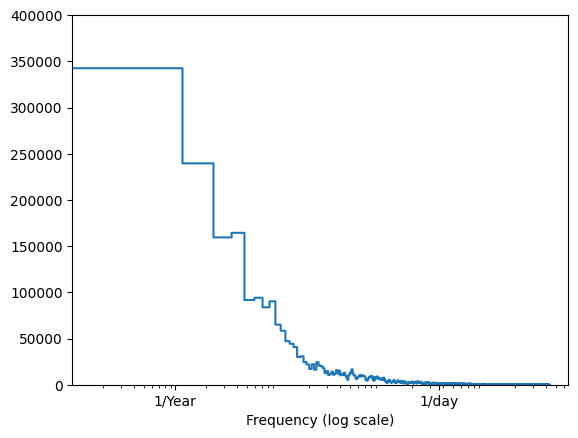

In [18]:
import tensorflow as tf
fft = tf.signal.rfft(df['Close'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['Close'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [19]:
df = df[['Open', 'High', 'Low', 'Close', 'day_sin', 'day_cos', 'trend_sma_fast', 'trend_sma_slow','trend_macd', 'KF_mean']]

In [20]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.8)]
val_df = df[int(n*0.8):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [21]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [22]:
df.head()

,Open,High,Low,Close,day_sin,day_cos,trend_sma_fast,trend_sma_slow,trend_macd,KF_mean
25,25.856570,26.379107,25.856570,26.379107,0.998717,-0.050649,25.643343,25.618167,0.145616,13.189553
26,26.325052,26.343070,26.234959,26.289015,0.968077,-0.250653,25.740945,25.654898,0.175953,17.613875
27,26.289012,26.343067,26.180901,26.343067,0.897805,-0.440394,25.835544,25.686776,0.202028,19.866196
28,26.361083,26.433157,26.234953,26.270990,0.790776,-0.612106,25.925636,25.713804,0.214405,21.219977
29,26.054773,26.072791,25.838551,26.000717,0.651372,-0.758758,25.966178,25.720041,0.200098,22.086473


In [23]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [24]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['Close'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['Close']

In [25]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [26]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 10)
Inputs shape: (3, 6, 10)
Labels shape: (3, 1, 1)


In [27]:
w2.example = example_inputs, example_labels

In [28]:
def plot(self, model=None, plot_col='Close', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [d]')

WindowGenerator.plot = plot

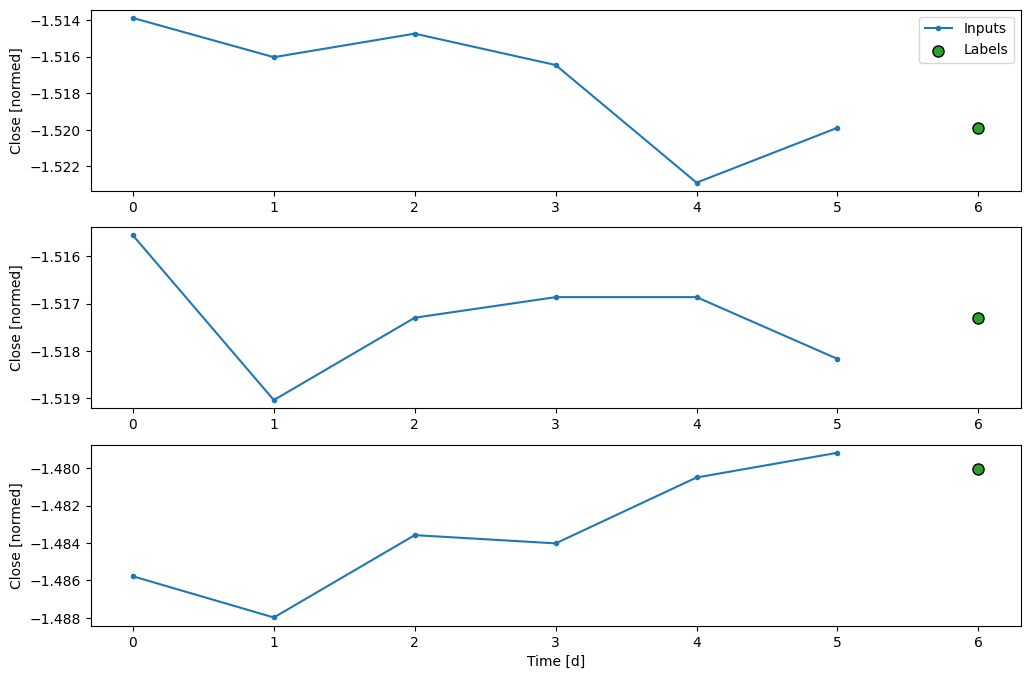

In [29]:
w2.plot()

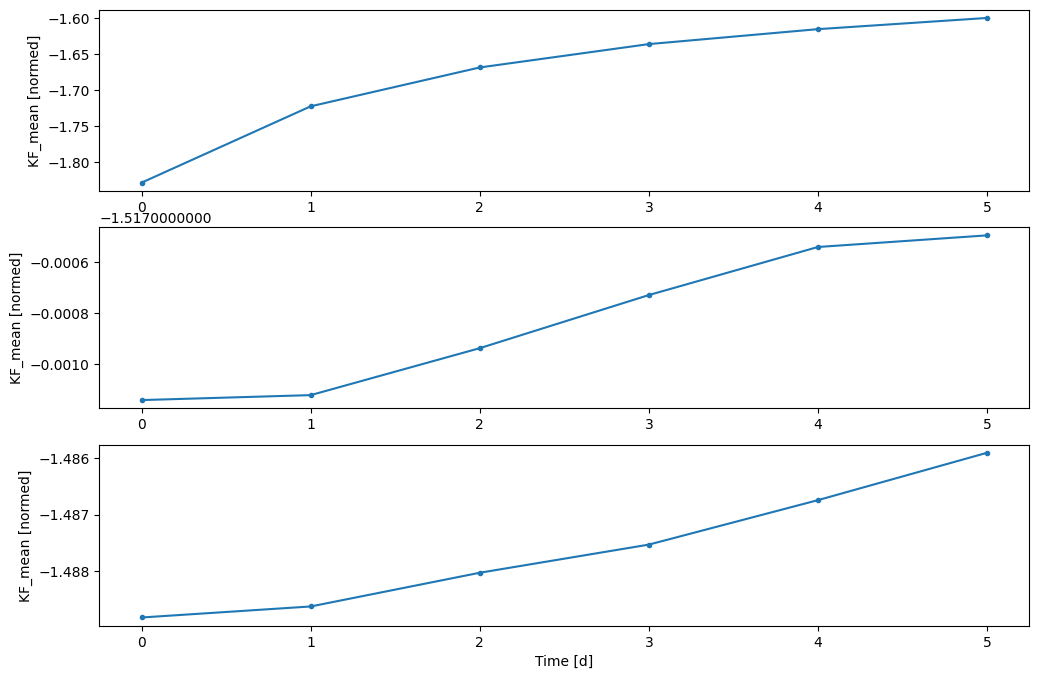

In [30]:
w2.plot(plot_col='KF_mean')

In [31]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [32]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [33]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 10), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [34]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 10)
Labels shape (batch, time, features): (32, 1, 1)


#### The following method packages the training procedure into a function

In [35]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [36]:
wide_window = WindowGenerator(
    input_width=30, label_width=30, shift=1,
    label_columns=['Close'])

wide_window

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Label column name(s): ['Close']

In [91]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True, kernel_regularizer='l1_l2'),
    # Shape => [batch, time, features]
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.GaussianNoise(0.001),
    tf.keras.layers.Dense(units=1)
])

In [92]:
lstm_model.build(wide_window.example[0].shape)
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (32, 30, 32)              5504      
                                                                 
 dropout_1 (Dropout)         (32, 30, 32)              0         
                                                                 
 gaussian_noise_1 (GaussianN  (32, 30, 32)             0         
 oise)                                                           
                                                                 
 dense_6 (Dense)             (32, 30, 1)               33        
                                                                 
Total params: 5,537
Trainable params: 5,537
Non-trainable params: 0
_________________________________________________________________


In [93]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 30, 10)
Output shape: (32, 30, 1)


In [94]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance = {}
performance = {}
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

23/23 [==============================] - 0s 5ms/step - loss: 0.1069 - mean_absolute_error: 0.2271


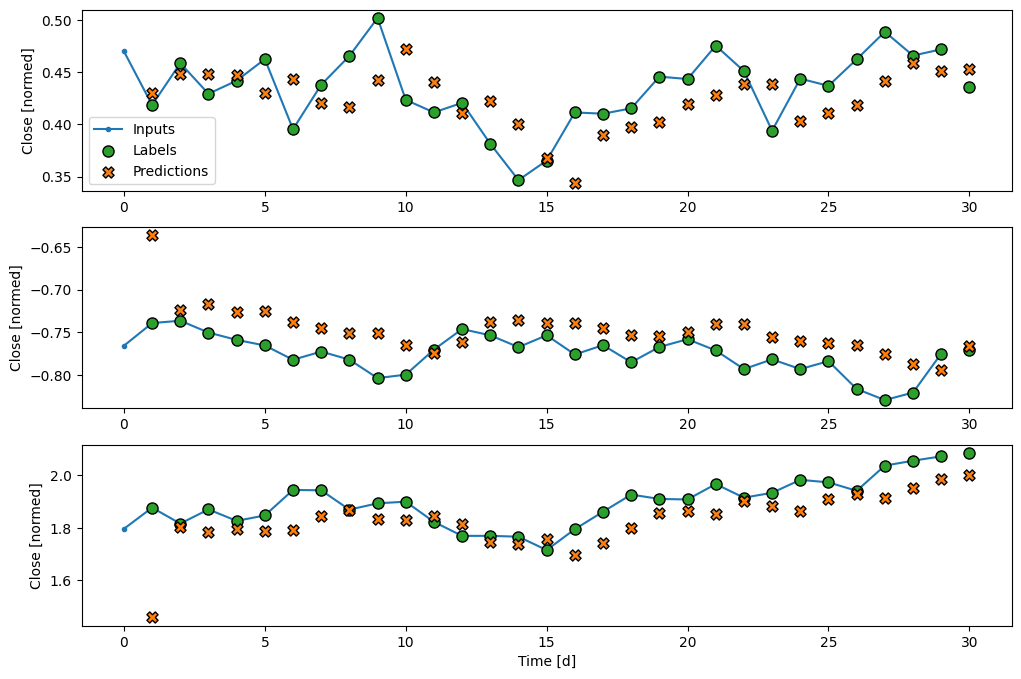

In [95]:
wide_window.plot(lstm_model)

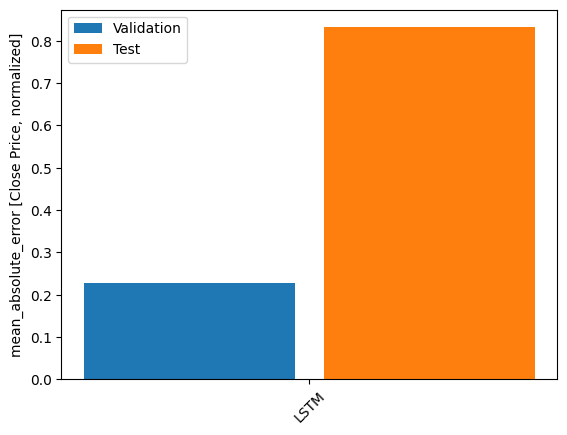

In [96]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [Close Price, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

Total window size: 12
Input indices: [0 1 2 3 4 5 6 7 8 9]
Label indices: [10 11]
Label column name(s): None

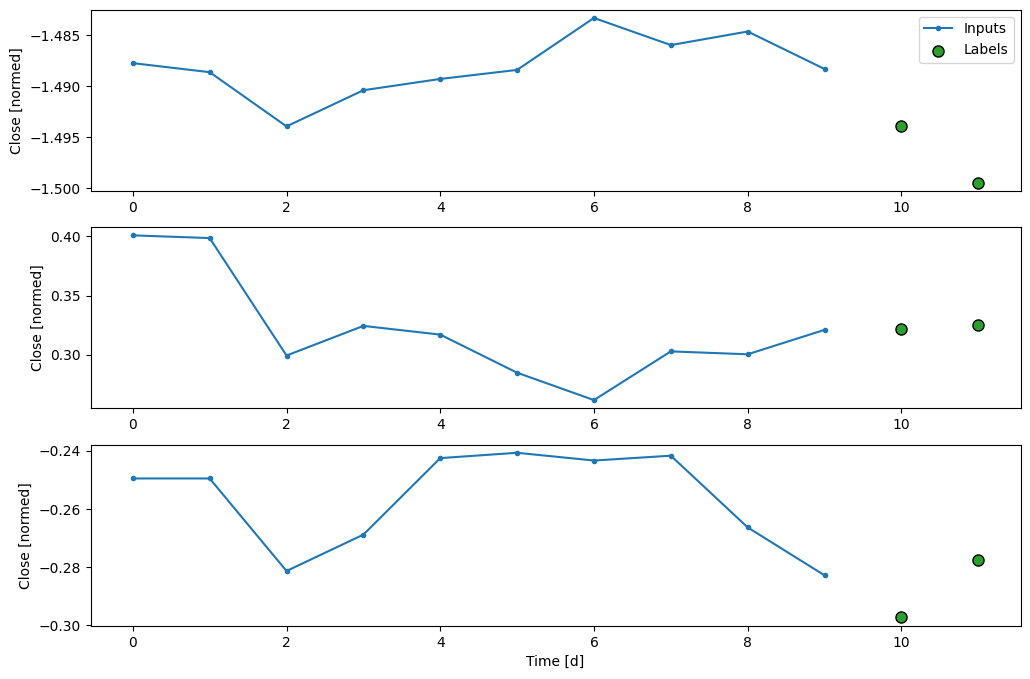

In [70]:
OUT_STEPS = 2
multi_window = WindowGenerator(input_width=10,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

In [87]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [88]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [89]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [90]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 10])

In [75]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [76]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 2, 10)


23/23 [==============================] - 0s 7ms/step - loss: 0.3710 - mean_absolute_error: 0.4803


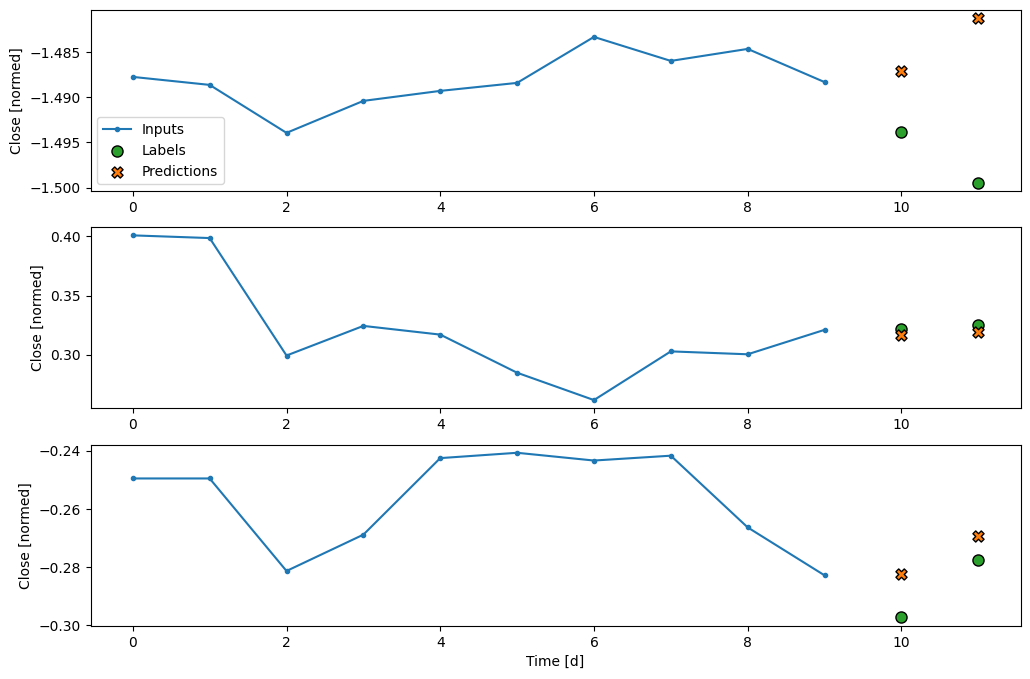

In [77]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance = {}
multi_performance = {}

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

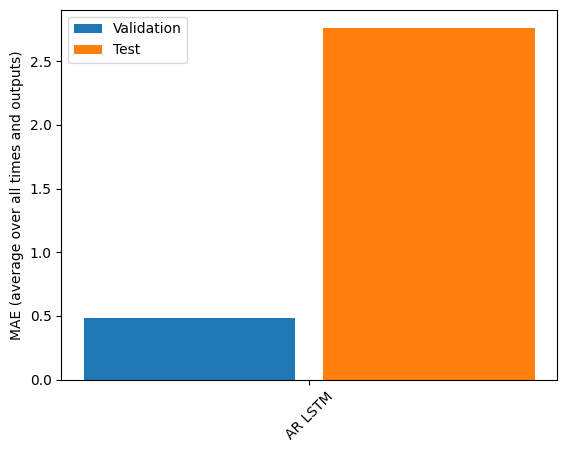

In [78]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()